In [ ]:
# README:
# This notebook compares and ESMPy regridding to an NCTools fregrid regridding. It is
# intended to serve as an example of how one might use ESMPy to do some NCTools compatible
# regridding. It also tries to make qualitiative and graphics comparisons of the results. 
# NCTools apps are not run here, instead the output files of make_hgrid and fregrid
# are read in.
# This notebook is similar to the xesmf_vs_nctools_cr notebook in goal, but it uses ESMPy classes
# directly. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import esmpy



In [2]:
#Load some functions we have defined in another notebook
%run esmpy_tuto_funcs.ipynb


In [3]:
# JUST A NOTE: There are potentialy usefull xesmf  utility functions, not just those
# that are automatically available through "import xesmf" , but those in other sections. 
# For example, some of the  xESMF "backend" functions imported like this (as per one of the xesmf tutorials):
#import xesmf as xe 
#from xesmf.backend import (
#    Grid,
#    esmf_regrid_build,
#    esmf_regrid_apply,
#)

In [4]:
# The source grid is a regular lat-lon grid
# This is initially and NCT (NCTools) grid; from make_hgrid
grid_s = grid_create_from_nct_rll("/home/mzuniga/xesmf_misc/nct/R180x360_grid.nc")
grid_s

Grid:
    type = <TypeKind.R8: 6>    areatype = <TypeKind.R8: 6>    rank = 2    num_peri_dims = 0    periodic_dim = None    pole_dim = None    pole_kind = None    coord_sys = <CoordSys.SPH_DEG: 1>    staggerloc = [True, False, False, True]    lower bounds = [array([0, 0], dtype=int32), None, None, array([0, 0], dtype=int32)]    upper bounds = [array([ 90, 180], dtype=int32), None, None, array([ 91, 181], dtype=int32)]    coords = [[array([[  1.,   3.,   5., ..., 355., 357., 359.],
       [  1.,   3.,   5., ..., 355., 357., 359.],
       [  1.,   3.,   5., ..., 355., 357., 359.],
       ...,
       [  1.,   3.,   5., ..., 355., 357., 359.],
       [  1.,   3.,   5., ..., 355., 357., 359.],
       [  1.,   3.,   5., ..., 355., 357., 359.]]), array([[-89., -89., -89., ..., -89., -89., -89.],
       [-87., -87., -87., ..., -87., -87., -87.],
       [-85., -85., -85., ..., -85., -85., -85.],
       ...,
       [ 85.,  85.,  85., ...,  85.,  85.,  85.],
       [ 87.,  87.,  87., ...,  87.,  

In [5]:
#The target grid, which also starts off as an NCT grid
# This grid of one degree resolution
grid_t = grid_create_from_nct_rll("/home/mzuniga/xesmf_misc/nct/R360x720_grid.nc")

In [6]:
#open a two degree dataset
#this is to be remapped to one degree
ds_s = xr.open_dataset("/home/mzuniga/nct_search/tests_xesmf/TestRR/R180x360.atmos_daily.nc")


In [7]:
ds_s

<xarray.Dataset>
Dimensions:       (grid_yt: 90, bnds: 2, grid_xt: 180, time: 8, pfull: 24)
Coordinates:
  * grid_yt       (grid_yt) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * grid_xt       (grid_xt) float32 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
  * time          (time) object 1980-01-01 12:00:00 ... 1980-01-08 12:00:00
  * pfull         (pfull) float32 3.65 19.09 52.34 99.13 ... 976.5 987.4 996.1
Dimensions without coordinates: bnds
Data variables:
    grid_yt_bnds  (grid_yt, bnds) float32 ...
    grid_xt_bnds  (grid_xt, bnds) float32 ...
    time_bounds   (time, bnds) timedelta64[ns] ...
    zsurf         (grid_yt, grid_xt) float32 ...
    temp          (time, pfull, grid_yt, grid_xt) float32 ...
    t_surf        (time, grid_yt, grid_xt) float32 ...
    average_T1    (time) datetime64[ns] ...
    average_T2    (time) datetime64[ns] ...
    average_DT    (time) timedelta64[ns] ...
Attributes:
    filename:              19800101.atmos_daily.tile1.nc
    title:                 c48_amip
    code_release_version:  2023.01
    git_hash:              dcbfc104e96d8e8e59cdd7696f6b0bc0807defff
    creationtime:          Mon Nov 13 17:44:07 2023
    hostname:              sanjuan
    history:               fregrid --input_mosaic R90x180_mosaic.nc --output_...

In [8]:
#RENAMING Coordiantes
#But this does not work:
#ds_s["lon"] = ds_s["grid_xt"]
#ds_s["lat"] = ds_s["grid_yt"]
#ds_s

ds_s = ds_s.rename({'grid_xt' : 'lon', 'grid_yt' : 'lat'})
ds_s 

<xarray.Dataset>
Dimensions:       (lat: 90, bnds: 2, lon: 180, time: 8, pfull: 24)
Coordinates:
  * lat           (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * time          (time) object 1980-01-01 12:00:00 ... 1980-01-08 12:00:00
  * pfull         (pfull) float32 3.65 19.09 52.34 99.13 ... 976.5 987.4 996.1
Dimensions without coordinates: bnds
Data variables:
    grid_yt_bnds  (lat, bnds) float32 ...
    grid_xt_bnds  (lon, bnds) float32 ...
    time_bounds   (time, bnds) timedelta64[ns] ...
    zsurf         (lat, lon) float32 ...
    temp          (time, pfull, lat, lon) float32 ...
    t_surf        (time, lat, lon) float32 ...
    average_T1    (time) datetime64[ns] ...
    average_T2    (time) datetime64[ns] ...
    average_DT    (time) timedelta64[ns] ...
Attributes:
    filename:              19800101.atmos_daily.tile1.nc
    title:                 c48_amip
    code_release_version:  2023.01
    git_hash:              dcbfc104e96d8e8e59cdd7696f6b0bc0807defff
    creationtime:          Mon Nov 13 17:44:07 2023
    hostname:              sanjuan
    history:               fregrid --input_mosaic R90x180_mosaic.nc --output_...

In [9]:
ds_s_temp = ds_s["temp"]
#temp is dour dimensional; select for one times and one pful
ds_s_temp = ds_s_temp [1][1]
ds_s_temp

<xarray.DataArray 'temp' (lat: 90, lon: 180)>
[16200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
    time     object 1980-01-02 12:00:00
    pfull    float32 19.09
Attributes:
    long_name:      temperature
    units:          K
    valid_range:    [100. 350.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order1

In [10]:
#Create the fields on the grids:
field_s = esmpy.Field(grid_s, name="temp")

In [11]:
#set the input (s) field values:
#note transpose may be needed here ?
#field_s.data[...] = np.transpose(ds_s_temp.to_numpy())
field_s.data[...] = ds_s_temp.to_numpy()

In [12]:
field_t = esmpy.Field(grid_t, name="temp")

In [13]:
#Create a regridder
regrider = esmpy.Regrid(field_s,field_t, regrid_method=esmpy.RegridMethod.CONSERVE,  
                     unmapped_action=esmpy.UnmappedAction.IGNORE)

In [18]:
#And do the regridding : field on 2 deg to field on  to 1 deg RLL
results_temp = regrider(field_s, field_t)
ds_t_temp = field_t.data

In [19]:
# the remapped temperature data is in field_t.data and also 
print (field_t) #or print results_temp 

Field:
    name = 'temp'
    type = <TypeKind.R8: 6>
    rank = 2
    extra dimensions = 0
    staggerloc = <StaggerLoc.CENTER: 0>
    lower bounds = array([0, 0], dtype=int32)
    upper bounds = array([180, 360], dtype=int32)
    extra bounds = None
    data = array([[216.4703064 , 216.4703064 , 216.4703064 , ..., 216.4662323 ,
        216.4662323 , 216.4662323 ],
       [216.4703064 , 216.4703064 , 216.4703064 , ..., 216.4662323 ,
        216.4662323 , 216.4662323 ],
       [216.4703064 , 216.4703064 , 216.4703064 , ..., 216.4662323 ,
        216.4662323 , 216.4662323 ],
       ...,
       [213.65232849, 213.65232849, 213.65232849, ..., 213.65478516,
        213.65478516, 213.65478516],
       [213.65232849, 213.65232849, 213.65232849, ..., 213.65478516,
        213.65478516, 213.65478516],
       [213.65232849, 213.65232849, 213.65232849, ..., 213.65478516,
        213.65478516, 213.65478516]])
    grid = 
Grid:
    type = <TypeKind.R8: 6>    areatype = <TypeKind.R8: 6>    rank = 2 

In [44]:
#The one degree dataset as remmapped by NCT
ds_t_nct = xr.open_dataset("/home/mzuniga/nct_search/tests_xesmf/TestRR/R360x720.atmos_daily.nc")
##temp is four dimentional. Select for one time and one pfull
ds_t_nct_temp = ds_t_nct.temp[1][1]
print (ds_t_nct_temp)
#print (ds_t_nct_temp.values)

<xarray.DataArray 'temp' (grid_yt: 180, grid_xt: 360)>
[64800 values with dtype=float32]
Coordinates:
  * grid_yt  (grid_yt) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * grid_xt  (grid_xt) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    time     object 1980-01-02 12:00:00
    pfull    float32 19.09
Attributes:
    long_name:      temperature
    units:          K
    valid_range:    [100. 350.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order1


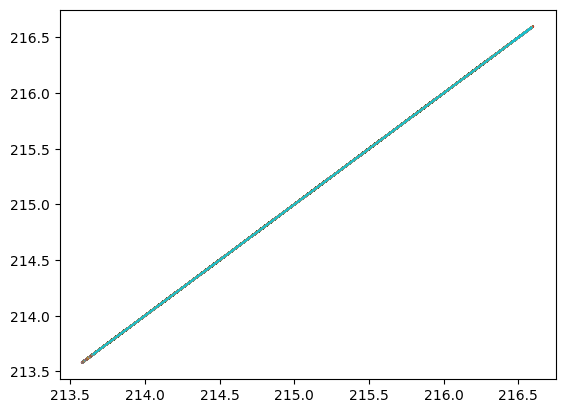

In [21]:
plt.plot(ds_t_temp, ds_t_nct_temp.values)
plt.show()


In [42]:
diff = ds_t_temp - ds_t_nct_temp.values
diff
#NOTE: Scaling by 100 for display purposes
diff = diff * 100

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -2.52953214e-10  0.00000000e+00]
 [-1.42108547e-11 -1.79056769e-10  7.38964445e-11 ...  1.73372428e-10
  -1.70530257e-11 -1.70530257e-11]
 [ 0.00000000e+00 -9.66338121e-11 -5.40012479e-11 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00 -5.11590770e-11 -6.25277607e-11 ...  0.00000000e+00
  -5.11590770e-11  0.00000000e+00]
 [-1.13686838e-11 -2.84217094e-12 -9.09494702e-11 ... -9.66338121e-11
   1.53477231e-10 -9.37916411e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.84217094e-12]]


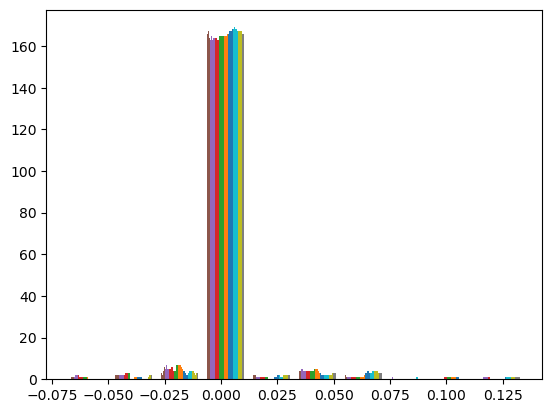

In [23]:
plt.hist(diff, 10)
plt.show()
#Note most discrepancies are within i part in ten thousand; some are not and up to about 1 part in a thousand

In [32]:
#Inspecting max error in the set index 

fdiff = diff.flatten()
me_idx  =  fdiff.argmax()
me_idx

50710

In [33]:
fd_v = fdiff [me_idx]


In [34]:
#Verify by printing the various componentrs
fd_v
#NOTE this below is really .00134 since data is scaled by 100 
# this is also about 6e-4 percent error ; error is inthe 6th significant digit

0.13466864113524935

In [35]:
ds_t_temp.flatten()[me_idx]

214.9826088934426

In [36]:
ds_t_nct_temp.values.flatten()[me_idx]

214.98126

In [37]:
#plot error magnitues with heat color map on sphere

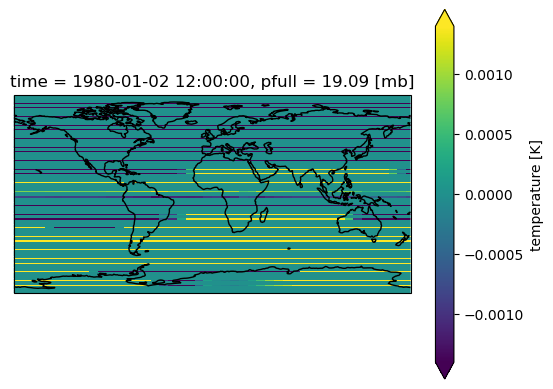

In [45]:
# max a copy of the xarray
diff2 = ds_t_nct_temp.copy(deep=True)
diff2.values = 100. * (diff2.values - ds_t_temp)
ax = plt.axes(projection=ccrs.PlateCarree())
diff2.plot.pcolormesh(ax=ax, vmin=-.0014, vmax=.0014)
ax.coastlines()